我们从现实中收集的数据，几乎不可能是完美无缺的，往往都会有一些缺失值。面对缺失值，很多人选择的方式是直接将含有缺失值的样本删除，这是一种有效的方法，但是有时候填补缺失值会比直接丢弃样本效果更好，即便我们其实并不知道缺失值的真实样貌。

在sklearn中，我们可以使用sklearn.impute.SimpleImputer来轻松地将均值，中值，或者其他最常用的数值填补到数据中，在这个案例中，我们将使用均值，0，和随机森林回归来填补缺失值，并验证四种状况下的拟合状况，找出对使用的数据集来说最佳的缺失值填补方法。

## 1、导库

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

## 2、以波士顿数据集为例，导入完整的数据集并探索

In [3]:
dataset = load_boston()
dataset.data.shape  # 总共506*13=6578个数据

D:\ANACONDA\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func

(506, 13)

In [4]:
X_full, y_full = dataset.data, dataset.target
n_samples = X_full.shape[0]  # 506
n_feature = X_full.shape[1]  # 13

## 3、为完整数据集制造缺失值

In [5]:
#首先确定我们希望放入的缺失数据的比例，在这里我们假设是50%，那总共就要有3289个数据缺失
rng = np.random.RandomState(0)
missing_rate = 0.5
n_missing_samples = int(np.floor(n_samples * n_feature * missing_rate))
#np.floor向下取整，返回.0格式的浮点数

#所有数据要随机遍布在数据集的各行各列当中，而一个缺失的数据会需要一个行索引和一个列索引
#如果能够创造一个数组，包含3289个分布在0~506中间的行索引，和3289个分布在0~13之间的列索引，那我们就可以利用索引来为数据中的任意3289个位置赋空值
#然后我们用0，均值和随机森林来填写这些缺失值，然后查看回归的结果如何
missing_features = rng.randint(0, n_feature, n_missing_samples)
missing_samples = rng.randint(0, n_samples, n_missing_samples)

X_missing = X_full.copy()
y_missing = y_full.copy()
X_missing[missing_samples, missing_features] = np.nan
X_missing = pd.DataFrame(X_missing)
#转换成DataFrame是为了后续方便各种操作，numpy对矩阵的运算速度快到拯救人生，但是在索引等功能上却不如pandas来得好用

## 4、使用0和均值填补缺失值

In [7]:
# 使用均值填补
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_missing_mean = imp_mean.fit_transform(X_missing)

# 使用0填补
imp_0 = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0)
X_missing_0 = imp_0.fit_transform(X_missing)

## 5、使用随机森林填补缺失值

In [18]:
"""
使用随机森林回归填补缺失值

任何回归都是从特征矩阵中学习，然后求解连续型标签y的过程，之所以能够实现这个过程，是因为回归算法认为，特征
矩阵和标签之前存在着某种联系。实际上，标签和特征是可以相互转换的，比如说，在一个“用地区，环境，附近学校数
量”预测“房价”的问题中，我们既可以用“地区”，“环境”，“附近学校数量”的数据来预测“房价”，也可以反过来，
用“环境”，“附近学校数量”和“房价”来预测“地区”。而回归填补缺失值，正是利用了这种思想。

对于一个有n个特征的数据来说，其中特征T有缺失值，我们就把特征T当作标签，其他的n-1个特征和原本的标签组成新
的特征矩阵。那对于T来说，它没有缺失的部分，这部分数据既有标签也有特征，可以用作我们训练模式；而它缺失的部
分，只有特征没有标签，就是我们需要预测的部分。

特征T不缺失的值对应的其他n-1个特征 + 本来的标签：X_train
特征T不缺失的值：Y_train

特征T缺失的值对应的其他n-1个特征 + 本来的标签：X_test
特征T缺失的值：未知，我们需要预测的Y_test 。预测出来后进行填补

这种做法，对于某一个特征大量缺失，其他特征却很完整的情况，非常适用。

那如果数据中除了特征T之外，其他特征也有缺失值怎么办？
答案是遍历所有的特征，从缺失最少的开始进行填补（因为填补缺失最少的特征所需要的准确信息最少）。
填补一个特征时，先将其他特征的缺失值用0代替，每完成一次回归预测，就将预测值放到原本的特征矩阵中，再继续填
补下一个特征。每一次填补完毕，有缺失值的特征会减少一个，所以每次循环后，需要用0来填补的特征就越来越少。当
进行到最后一个特征时（这个特征应该是所有特征中缺失值最多的），已经没有任何的其他特征需要用0来进行填补了，
而我们已经使用回归为其他特征填补了大量有效信息，可以用来填补缺失最多的特征。
遍历所有的特征后，数据就完整，不再有缺失值了。

你学废了吗？
"""
X_missing_reg = X_missing.copy()
# argsort 返回的是元素值从小到大排序后的对应索引值 从缺失值最少的特征开始填充
sortindex = np.argsort(X_missing_reg.isnull().sum(axis=0)).values

for i in sortindex:
    # 构建新特征矩阵和新标签
    df = X_missing_reg
    fillc = df.iloc[:, i]
    df = pd.concat([df.iloc[:, df.columns != i], pd.DataFrame(y_full)], axis=1)

    # 在新特征矩阵中，对含有缺失值的列进行0的填充
    df_0 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0).fit_transform(df)

    # 找出训练集和测试集
    Ytrain = fillc[fillc.notnull()]
    Ytest = fillc[fillc.isnull()]
    Xtrain = df_0[Ytrain.index, :]
    Xtest = df_0[Ytest.index, :]

    # 使用随机森林回归填补缺失值
    rfc = RandomForestRegressor(n_estimators=100)
    rfc = rfc.fit(Xtrain, Ytrain)
    Ypredict = rfc.predict(Xtest)

    # 将填补好的特征返回到我们的原始的特征矩阵中
    X_missing_reg.loc[X_missing_reg.iloc[:, i].isnull(), i] = Ypredict

## 6、对填补好的数据进行建模

In [19]:
# 对所有数据进行建模，取得MSE结果
X = [X_full, X_missing_mean, X_missing_0, X_missing_reg]

mse = []
std = []
for x in X:
    estimator = RandomForestRegressor(random_state=0, n_estimators=100)
    scores = cross_val_score(estimator, x, y_full, scoring='neg_mean_squared_error', cv=5).mean()
    mse.append(scores * -1)

## 7、用所得结果画出条形图

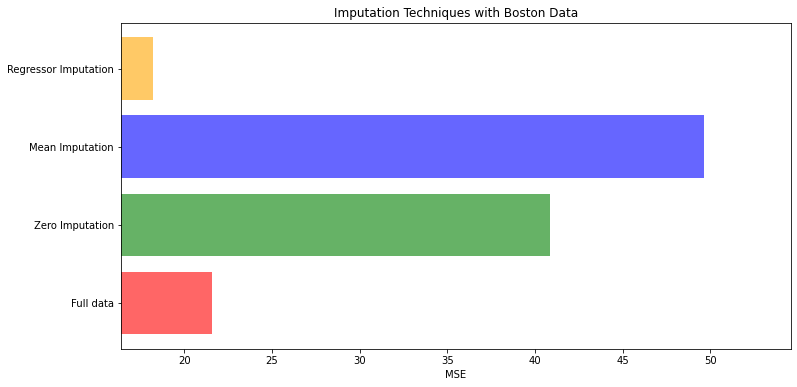

In [27]:
x_labels = ['Full data',
            'Zero Imputation',
            'Mean Imputation',
            'Regressor Imputation']
colors = ['r', 'g', 'b', 'orange']
plt.figure(figsize=(12, 6))
ax = plt.subplot(111)
for i in np.arange(len(mse)):
    ax.barh(i, mse[i], color=colors[i], alpha=0.6, align='center')
ax.set_title('Imputation Techniques with Boston Data')
ax.set_xlim(left=np.min(mse) * 0.9, right=np.max(mse) * 1.1)
ax.set_yticks(np.arange(len(mse)))
ax.set_xlabel('MSE')
ax.set_yticklabels(x_labels)
plt.show()